In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
#%matplotlib qt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks

from random import random

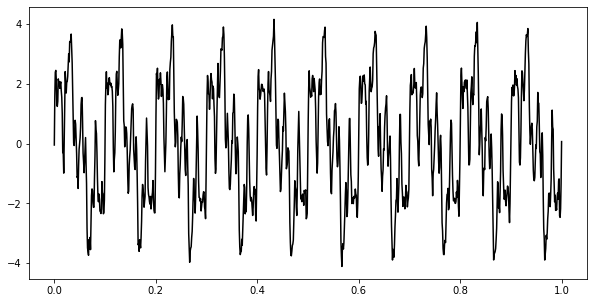

In [2]:
t = np.linspace(0,1,1024)
f1, f2, f3, f4 = 10, 40, 100, 150
Fort=2.0*np.sin(2*np.pi*f1*t)+1.5*np.sin(2*np.pi*f2*t)+0.8*np.sin(2*np.pi*f3*t)+0.5*np.sin(2*np.pi*f4*t)+0.2*np.random.randn(len(t))+0.01*t
plt.figure(figsize = (10, 5))
plt.plot(t, Fort, 'k')
plt.show()

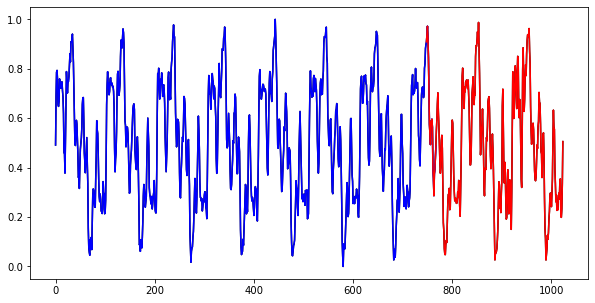

In [3]:
n_point=20 #Количество предыдущих точек, по которым предсказывается следующее значение
fn_tr=768 #Конец обучающей выборки
st_test=fn_tr-n_point #Начало тестовой выборки
fn_test=1024 #Конец тестовой выборки
len_f=1024 #Длина исходного ВР


Ft=Fort
Ft[900:950]=Ft[900:950]+np.sin(2*np.pi*200*t[900:950]) #Вносим искусственную аномалию во ВР
scaler = MinMaxScaler(feature_range=(0, 1))
F=np.array(Ft[:len_f])
F = F.reshape(-1, 1)
F = scaler.fit_transform(F)
F_tr = F[:fn_tr]
F_test = F[st_test:]
plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:fn_tr],F_tr, 'b')
plt.plot(np.r_[st_test:fn_test],F_test, 'r')
plt.show()

In [4]:
#Предобработка исходных данных в формат, понимаемый слоем GRU-сети, в виде «порций» (batches) для обучения/валидации
from keras.preprocessing.sequence import TimeseriesGenerator
data_gen_tr = TimeseriesGenerator(F_tr, F_tr, length=n_point, sampling_rate=1, batch_size=fn_tr)
batch_0_tr = data_gen_tr[0]
x_tr, y_tr = batch_0_tr # вход и обучающий выход для сети
print(x_tr.shape) #Точки обучения
xx_tr=np.reshape(x_tr, (x_tr.shape[0], 1, x_tr.shape[1]))
yy_tr=y_tr
print(xx_tr.shape) # меняем местами размерности
print(yy_tr.shape) 

(748, 20, 1)
(748, 1, 20)
(748, 1)


In [5]:
#Для тестовой проверки прогноза исходные точки аналогично представим в виде «порций»
data_gen_test = TimeseriesGenerator(F_test, F_test, length=n_point, sampling_rate=1, batch_size=fn_tr)
batch_0_test = data_gen_test[0]
x_test, y_test = batch_0_test
xx_test=np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
yy_test = y_test
print(xx_test.shape) 
print(yy_test.shape) 

(256, 1, 20)
(256, 1)


In [6]:
#Модель из 3 слоев GRU
from tensorflow.keras.utils import plot_model
model = Sequential()
model.add(GRU(units=40, return_sequences=True, input_shape=(1, n_point)))
model.add(Dropout(0.3))
model.add(GRU(units=40, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=40))
model.add(Dense(units = 1))
model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 40)             7440      
_________________________________________________________________
dropout (Dropout)            (None, 1, 40)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 40)             9840      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 40)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 40)                9840      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 27,161
Trainable params: 27,161
Non-trainable params: 0
____________________________________________________

In [8]:
#Производим обучение нашей модели
history = model.fit(xx_tr, yy_tr, validation_data=(xx_test, yy_test), epochs = 100, verbose=1) # 100 эпох

Epoch 1/100
24/24 [==============================] - 28s 214ms/step - loss: 0.1207 - val_loss: 0.0518
Epoch 2/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0435 - val_loss: 0.0302
Epoch 3/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0315 - val_loss: 0.0219
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0234 - val_loss: 0.0150
Epoch 5/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0192 - val_loss: 0.0114
Epoch 6/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0150 - val_loss: 0.0090
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0131 - val_loss: 0.0079
Epoch 8/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0119 - val_loss: 0.0074
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0074
Epoch 10/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0103 - val_loss: 0.00

In [9]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure(figsize = (10, 5))
  plt.plot(epochs, loss, 'b', label='Потери при обучении')
  plt.plot(epochs, val_loss, 'r', label='Потери при проверке')
  plt.title(title)
  plt.legend()
  plt.show()

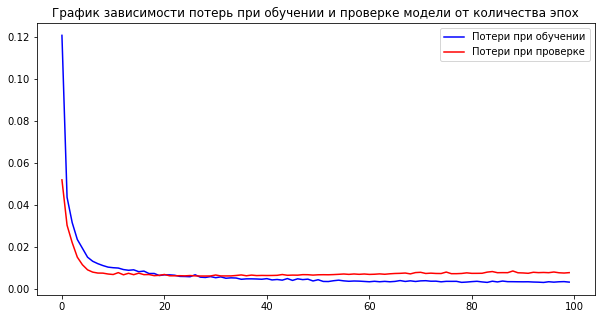

In [10]:
#%matplotlib qt
plot_train_history(history,
                   'График зависимости потерь при обучении и проверке модели от количества эпох')

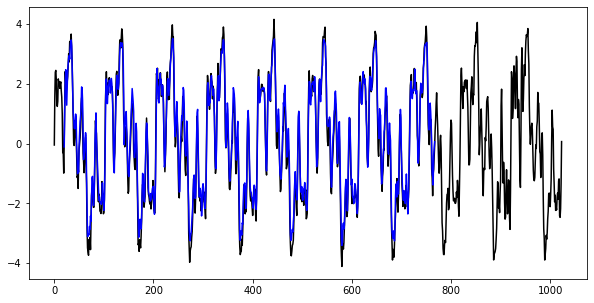

In [11]:
#Построим ретроспективный прогноз
trainPredict = model.predict(xx_tr)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Ft[:len_f], 'k')
plt.plot(np.r_[n_point:fn_tr],trainPredict, 'b')
plt.show()

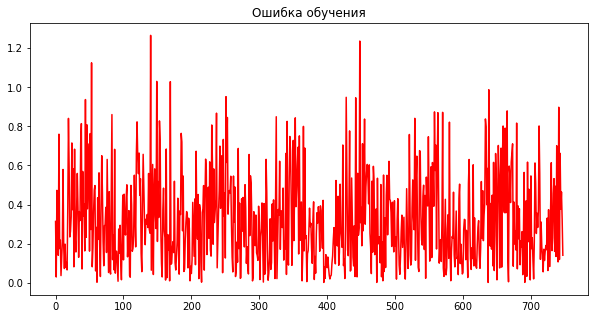

In [12]:
#Ошибка
FF1=np.array(Ft[n_point:fn_tr]).reshape(-1,1)
er1=abs(FF1-trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(er1, 'r')
plt.title('Ошибка обучения')
plt.show()

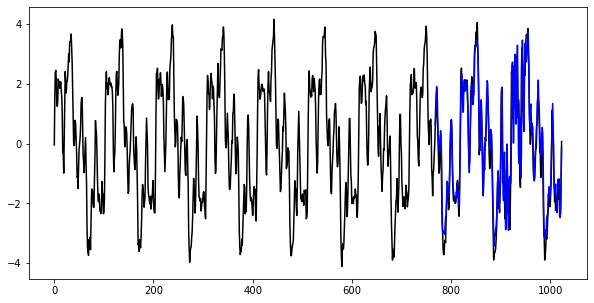

In [13]:
#Строим получившийся тестовый прогноз в нужном масштабе
#%matplotlib qt
testPredict = model.predict(xx_test)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Ft[:len_f], 'k')
plt.plot(np.r_[fn_tr:len_f],testPredict, 'b')
plt.show()
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)


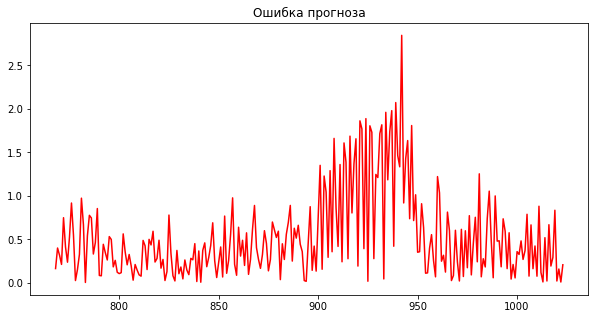

In [14]:
#Ошибка
FF=np.array(Ft[fn_tr:len_f]).reshape(-1,1)
er=abs(FF-testPredict)
plt.figure(figsize = (10, 5))
plt.plot(np.r_[fn_tr:len_f],er, 'r')
plt.title('Ошибка прогноза')
plt.show()


In [15]:
print('Матожидание ошибки обучения = ', round(np.mean(er1),5))
print('СКВО ошибки обучения = ', round(np.std(er1),5))
print('Матожидание ошибки прогноза = ', round(np.mean(er),5))
print('СКВО ошибки прогноза = ', round(np.std(er),5))

Матожидание ошибки обучения =  0.32281
СКВО ошибки обучения =  0.23377
Матожидание ошибки прогноза =  0.52766
СКВО ошибки прогноза =  0.495


In [16]:
#Скользящее сглаживание по k точкам
def moving_average(series, Date, k):
    f2=[]
    Dt=[]
    N1=int(len(series))
    k1=int((k-1)/2)
    i=k1+1
    while i<= N1-k1:
        tmp=series[i-k1:i+k1]   
        f2.append(np.mean(tmp))
        Dt.append(Date[i])
        i=i+1
    return Dt, f2

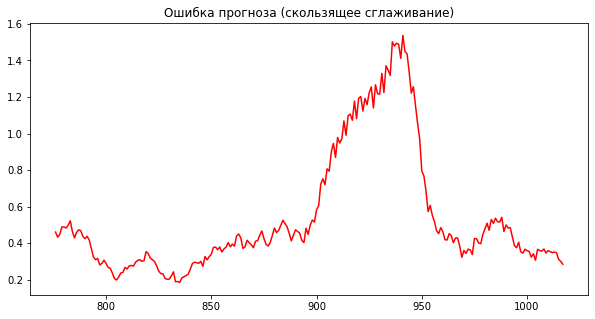

In [17]:
#Скользящее сглаживание ошибки прогноза
[t1,s1] = moving_average(er,np.r_[fn_tr:len_f],15)
plt.figure(figsize = (10, 5))
plt.plot(t1, s1, 'r')
plt.title('Ошибка прогноза (скользящее сглаживание)')
plt.show()